In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils.plot_utils import set_fontsize
from utils.binning_utils import bin_dataset_switching
from utils.hdf_utils import load_measurement_data_devices_attrs
from utils.plot_utils import plot_binned_dataset_switching
from utils.binning_utils import bin_data, find_nearest_idx, combine_arrays_irregular, \
                                average_binned_data, bin_dataset_switching

# Measurement with $\phi$ modulation
stepping through the following sequence  
* phase mod off, shutter closed  
* phase mod off, shutter open  
* phase mod on, shutter closed  
* phase mod on, shutter open  

at low UV detection power (5mW) and 36.5 mW UV rotational cooling power.  
Polarization switching for both lasers is on:  
* 1.62 MHz detection laser
* 1.5 MHz rotational cooling laser

In [2]:
fname = "2020_10_8.hdf"
dset_name = "1602188573 test_phase_mod_rc"

dset_names = [dset_name]
devices = ('Laser Lock', 'Wavelength', 'ZaberTMM', 'SDG1032X')

In [3]:
pmt_channel = 1
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(fname, dset_name, devices)

In [4]:
import copy

# combinations
shutter_states = ['open', 'closed']
phi_states     = ['on', 'off']

data_grouped = {'on': {'open':[], 'closed':[]} ,
                'off':{'open':[], 'closed':[]}}
indices_grouped = copy.deepcopy(data_grouped)

In [5]:
ch = 1
for idx in range(1,len(pxie)+1):
    attrs = pxie_attrs[idx]
    phi = 'on' if int(attrs['SDG1032X SetOutputState1']) else 'off'
    if attrs['ShutterControl SetVoltage'] == '0':
        indices_grouped[phi]['closed'].append(idx)
        data_grouped[phi]['closed'].append(pxie[idx][:,ch])
    elif attrs['ShutterControl SetVoltage'] == '5':
        indices_grouped[phi]['open'].append(idx)
        data_grouped[phi]['open'].append(pxie[idx][:,ch])

phi mod on -> integral ratio : 2.31719 +/- 0.11572
phi mod off -> integral ratio : 2.33388 +/- 0.12424


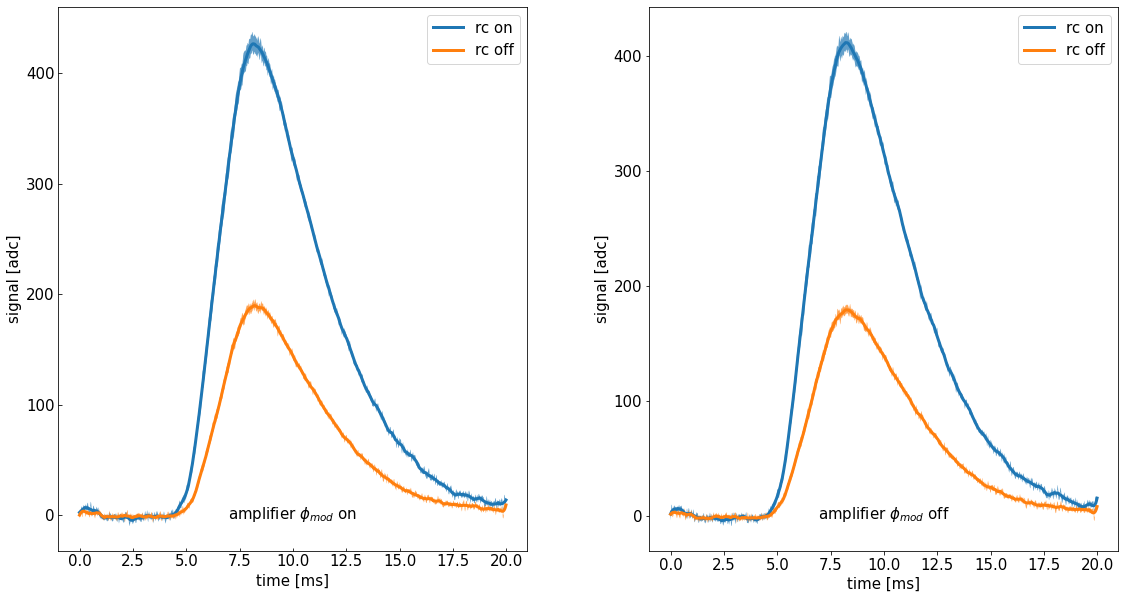

In [6]:
from scipy.signal import savgol_filter

figf, axf = plt.subplots(1,2,figsize = (19,10), sharex = True, 
            gridspec_kw={'hspace': 0, 'wspace': .26})

axp = {p:ax for p,ax in zip(phi_states, axf.flatten())}

ratios = []

for p in phi_states:
    yo = np.mean(data_grouped[p]['open'], axis = 0)
    yc = np.mean(data_grouped[p]['closed'], axis = 0)
    yo -= np.mean(yo[:300])
    yc -= np.mean(yc[:300])

    lo = len(data_grouped[p]['open'])
    lc = len(data_grouped[p]['closed'])

    syo = np.std(data_grouped[p]['open'], axis = 0)
    syo /= np.sqrt(lo)
    syc = np.std(data_grouped[p]['closed'], axis = 0)
    syc /= np.sqrt(lc)

    x = np.linspace(0,1999,2000)/100
    
    trapzo = np.trapz(-yo)
    trapzc = np.trapz(-yc)
    trapz_error = (trapzo/trapzc)*np.sqrt((np.sum(syo)/trapzo)**2 + (np.sum(syc)/trapzc)**2)
    
    ratios.append((np.trapz(-yo)/np.trapz(-yc), trapz_error))
    
    print(f'phi mod {p} -> integral ratio : {np.trapz(-yo)/np.trapz(-yc):.5f} +/- {trapz_error:.5f}')
    
    if p in axp:
        axp[p].fill_between(x, -yo-syo, -yo+syo, alpha = .7)
        axp[p].fill_between(x, -yc-syc, -yc+syc, alpha = .7)
        axp[p].plot(x, -savgol_filter(yo, 51, 3), lw = 3, label= 'rc on')
        axp[p].plot(x, -savgol_filter(yc, 51, 3), lw = 3, label = 'rc off')
        axp[p].set_xlabel('time [ms]')
        axp[p].set_ylabel('signal [adc]')
        axp[p].text(0.5, 0.05, f'amplifier $\phi_{{mod}}$ {p}', transform=axp[p].transAxes, fontsize = 15,
                   ha = 'center', va = 'bottom')
        
        axp[p].legend(fontsize = 15)
        set_fontsize(axp[p], 15)
for ax in list(axp.values())[:len(axp)//2]:
    ax.tick_params(direction = 'in')

figf.align_ylabels()
    
# figf.savefig(f'linearity.png', dpi = 300, bbox_inches='tight')

In [7]:
states = {0: ['off', 'closed'],
          1: ['off', 'open'],
          2: ['on', 'closed'],
          3: ['on', 'open']}

indices_grouped_bunched = {'on': {'open':[], 'closed':[]} ,
                           'off':{'open':[], 'closed':[[]]}}

idx = 1
cnt = 1
s = 0
while idx < len(pxie):
    indices_grouped_bunched[states[s][0]][states[s][1]][-1].append(idx)
    if (cnt%10 == 0) & (cnt != 0):
        cnt = 1
        idx += 1
        s += 1
        if (s%4==0) & (s != 0):
            s=0
        indices_grouped_bunched[states[s][0]][states[s][1]].append([])
        continue
    idx += 1
    cnt += 1

In [8]:
def bunched_integral(indices, phi_state, shutter_state):
    integral = []
    for indices in indices_grouped_bunched[phi_state][shutter_state]:
        tmp = []
        for idx in indices:
            tmp.append(pxie[idx][:,ch])        
        sy = np.sum(np.std(tmp, axis = 0))
        sy /= np.sqrt(len(tmp))

        tmp = np.mean(tmp, axis = 0)
        integral.append((np.trapz(-(tmp-np.mean(tmp[:300]))), sy))
    return integral

In [9]:
integral1 = bunched_integral(indices_grouped_bunched, 'on', 'open')
integral2 = bunched_integral(indices_grouped_bunched, 'on', 'closed')
integral3 = bunched_integral(indices_grouped_bunched, 'off', 'open')
integral4 = bunched_integral(indices_grouped_bunched, 'off', 'closed')

In [10]:
def unpack_integrals(integral):
    intvals,sintvals = list(zip(*integral))
    return np.array(intvals), np.array(sintvals)

int1, sint1 = unpack_integrals(integral1)
int2, sint2 = unpack_integrals(integral2)
int3, sint3 = unpack_integrals(integral3)
int4, sint4 = unpack_integrals(integral4)

In [11]:
def ratio_error(val1, val2, sval1, sval2):
    return (val1/val2)*np.sqrt((sval1/val1)**2+(sval2/val2)**2)

ratio_phimod_on = int1/int2
sigma_ratio_phimod_on = ratio_error(int1, int2, sint1, sint2)
ratio_phimod_off = int3/int4
sigma_ratio_phimod_off = ratio_error(int3, int4, sint3, sint4)

In [12]:
def plot_ratio(ratio, sigma_ratio, cutoff, title):
    x = np.arange(1,len(ratio)+1)
    m = ratio < cutoff

    fig, ax = plt.subplots(figsize = (10,6))
    ax.errorbar(x[m], ratio[m], yerr = sigma_ratio[m], fmt = '.', ecolor = 'C3', ms = 10)

    mean = np.average(ratio[m], weights = 1/sigma_ratio[m]**2)
    sigma = np.sqrt(1/np.sum(1/sigma_ratio[m]**2))

    ax.hlines(mean, xmin = x[m].min(), xmax = x[m].max(), color = 'k', zorder = 0)
    ax.fill_between(x[m], mean - sigma, mean+sigma, zorder = 0, alpha = 0.4, color = 'k')

    ax.set_ylim(0,cutoff)

    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    s = f'ratio = {mean:.2f}$\pm${sigma:.2f}'
    ax.text(0.5, 0.05, s, va = 'bottom', ha = 'center', transform = ax.transAxes, 
            fontsize = 14, bbox=props)
    
    ax.set_title(title)
    ax.set_ylabel('ratio rc on / rc off')
    
    set_fontsize(ax, 14)

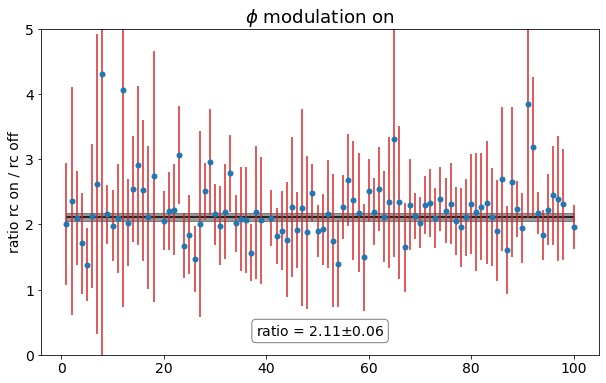

In [13]:
plot_ratio(ratio_phimod_on, sigma_ratio_phimod_on, 5, '$\phi$ modulation on')

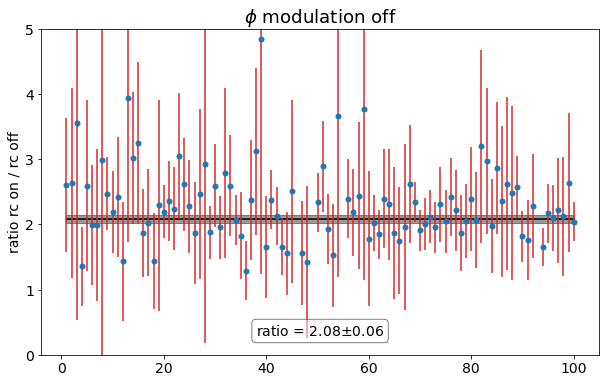

In [14]:
plot_ratio(ratio_phimod_off, sigma_ratio_phimod_off, 5, '$\phi$ modulation off')

In [15]:
gammap = lambda gamma, rabi: 2*np.sqrt(gamma**2/4 + rabi**2/2)

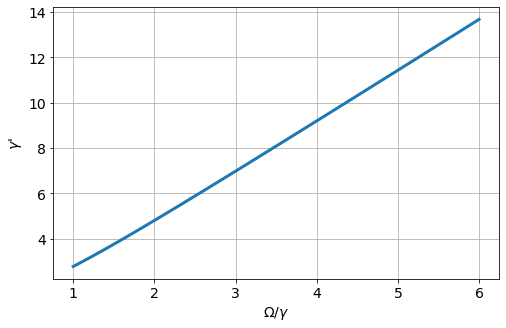

In [16]:
x = np.linspace(1,6,101)
gamma = 1.6

fig, ax = plt.subplots(figsize = (8,5))

ax.plot(x, gammap(gamma, gamma*x), lw = 3)
ax.set_xlabel(r'$\Omega/\gamma$')
ax.set_ylabel(r"$\gamma$'")
ax.grid(True)

set_fontsize(ax, 14)